In [1]:
from functools import partial

from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import dimensionless, galactic, UnitSystem

import jax
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)

import scienceplots
import cmasher as cmr
plt.style.use('science')
import jax.random as random 
from matplotlib.patches import Ellipse

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [103]:
class Potential:
    
    def __init__(self, units, params):
        if units is None:
            units = dimensionless
        self.units = UnitSystem(units)
        
        if self.units == dimensionless:
            self._G = 1
        else:
            self._G = G.decompose(self.units).value
        
        for name, param in params.items():
            if hasattr(param, 'unit'):
                param = param.decompose(self.units).value
            setattr(self, name, param)
    
    @partial(jax.jit, static_argnums=(0,))
    def gradient(self, xyz, t):
        grad_func = jax.grad(self.potential)
        return grad_func(xyz, t)
    
    @partial(jax.jit, static_argnums=(0,))
    def density(self, xyz, t):
        lap = jnp.trace(jax.hessian(self.potential)(xyz, t))
        return lap / (4 * jnp.pi * self._G)
    
    @partial(jax.jit, static_argnums=(0,))
    def acceleration(self, xyz, t):
        return -self.gradient(xyz, t)
    
   
    @partial(jax.jit,static_argnums=(0,))
    def jacobian_force_mw(self, xyz, t):
        jacobian_force_mw = jax.jacfwd(self.gradient)
        return jacobian_force_mw(xyz, t)
    
    @partial(jax.jit,static_argnums=(0,))
    def d2phidr2_mw(self, x, t):
        """
        Computes the second derivative of the Milky Way potential at a position x (in the simulation frame)
        Args:
          x: 3d position (x, y, z) in [kpc]
        Returns:
          Second derivative of force (per unit mass) in [1/Myr^2]
        Examples
        --------
        >>> d2phidr2_mw(x=jnp.array([8.0, 0.0, 0.0]))
        """
        rad = jnp.linalg.norm(x)
        r_hat = x/rad
        dphi_dr_func = lambda x: jnp.sum(self.gradient(x,t)*r_hat)
        return jnp.sum(jax.grad(dphi_dr_func)(x)*r_hat)
        
        ##return jnp.matmul(jnp.transpose(x), jnp.matmul(self.jacobian_force_mw(x, t), x)) / rad**2


    @partial(jax.jit,static_argnums=(0,))
    def omega(self, x,v):
        """
        Computes the magnitude of the angular momentum in the simulation frame
        Args:
          x: 3d position (x, y, z) in [kpc]
          v: 3d velocity (v_x, v_y, v_z) in [kpc/Myr]
        Returns:
          Magnitude of angular momentum in [rad/Myr]
        Examples
        --------
        >>> omega(x=jnp.array([8.0, 0.0, 0.0]), v=jnp.array([8.0, 0.0, 0.0]))
        """
        rad = jnp.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2)
        omega_vec = jnp.cross(x, v) / (rad**2)
        return jnp.linalg.norm(omega_vec)

    @partial(jax.jit,static_argnums=(0,))
    def tidalr_mw(self, x, v, Msat, t):
        """
        Computes the tidal radius of a cluster in the potential
        Args:
          x: 3d position (x, y, z) in [kpc]
          v: 3d velocity (v_x, v_y, v_z) in [kpc/Myr]
          Msat: Cluster mass in [Msol]
        Returns:
          Tidal radius of the cluster in [kpc]
        Examples
        --------
        >>> tidalr_mw(x=jnp.array([8.0, 0.0, 0.0]), v=jnp.array([8.0, 0.0, 0.0]), Msat=1e4)
        """
        return (self._G * Msat / ( self.omega(x, v) ** 2 - self.d2phidr2_mw(x, t)) ) ** (1.0 / 3.0)
    
    @partial(jax.jit,static_argnums=(0,))
    def lagrange_pts(self,x,v,Msat, t):
        r_tidal = self.tidalr_mw(x,v,Msat, t)
        r_hat = x/jnp.linalg.norm(x)
        L_close = x - r_hat*r_tidal
        L_far = x + r_hat*r_tidal
        return L_close, L_far
    
    @partial(jax.jit,static_argnums=(0,))
    def release_model(self, x, v, Msat, pos_disp, vel_disp,i, t):
        """
        Simplification of particle spray: just release particles in gaussian blob at each lagrange point.
        User sets the spatial and velocity dispersion for the "leaking" of particles
        TODO: change random key handling... need to do all of the sampling up front...
        """
        keya = jax.random.PRNGKey(i*13)
        keyb = jax.random.PRNGKey(i*23)
        
        keyc = jax.random.PRNGKey(i*27)
        keyd = jax.random.PRNGKey(i*3)
        keye = jax.random.PRNGKey(i*17)
        
        L_close, L_far = self.lagrange_pts(x,v,Msat, t) # each is an xyz array
        
        omega_val = self.omega(x,v)
        
        
        r = jnp.linalg.norm(x)
        r_hat = x/r
        r_tidal = self.tidalr_mw(x,v,Msat, t)
        rel_v = omega_val*r_tidal #relative velocity
        
        #circlar_velocity
        dphi_dr = jnp.sum(self.gradient(x, t)*r_hat)
        v_circ = rel_v##jnp.sqrt( r*dphi_dr )
        
        L_vec = jnp.cross(x,v)
        z_hat = L_vec / jnp.linalg.norm(L_vec)
        
        phi_vec = v - jnp.sum(v*r_hat)*r_hat
        phi_hat = phi_vec/jnp.linalg.norm(phi_vec)
        vt_sat = jnp.sum(v*phi_hat)
        
        
        kr_bar = 2.0
        kvphi_bar = 0.3
        ####################kvt_bar = 0.3 ## FROM GALA
        
        kz_bar = 0.0
        kvz_bar = 0.0
        
        sigma_kr = 0.5
        sigma_kvphi = 0.5
        sigma_kz = 0.5
        sigma_kvz = 0.5
        ##############sigma_kvt = 0.5 ##FROM GALA
        
        kr_samp =  kr_bar + jax.random.normal(keya,shape=(1,))*sigma_kr
        kvphi_samp = kr_samp*(kvphi_bar  + jax.random.normal(keyb,shape=(1,))*sigma_kvphi)
        kz_samp = kz_bar + jax.random.normal(keyc,shape=(1,))*sigma_kz
        kvz_samp = kvz_bar + jax.random.normal(keyd,shape=(1,))*sigma_kvz
        ########kvt_samp = kvt_bar + jax.random.normal(keye,shape=(1,))*sigma_kvt
        
        ## Trailing arm
        pos_trail = x + kr_samp*r_hat*(r_tidal) #nudge out
        pos_trail  = pos_trail + z_hat*kz_samp*(r_tidal/1.0)#r #nudge above/below orbital plane
        v_trail = v + (0.0 + kvphi_samp*v_circ*(1.0))*phi_hat#v + (0.0 + kvphi_samp*v_circ*(-r_tidal/r))*phi_hat #nudge velocity along tangential direction
        v_trail = v_trail + (kvz_samp*v_circ*(1.0))*z_hat#v_trail + (kvz_samp*v_circ*(-r_tidal/r))*z_hat #nudge velocity along vertical direction
        
        ## Leading arm
        pos_lead = x + kr_samp*r_hat*(-r_tidal) #nudge in
        pos_lead  = pos_lead + z_hat*kz_samp*(-r_tidal/1.0)#r #nudge above/below orbital plane
        v_lead = v + (0.0 + kvphi_samp*v_circ*(-1.0))*phi_hat#v + (0.0 + kvphi_samp*v_circ*(r_tidal/r))*phi_hat #nudge velocity along tangential direction
        v_lead = v_lead + (kvz_samp*v_circ*(-1.0))*z_hat#v_lead + (kvz_samp*v_circ*(r_tidal/r))*z_hat #nudge velocity against vertical direction
        
    
        
        ###print(L_close, L_far)
        #pos_release_close = L_close + jax.random.normal(keya,shape=(3,))*pos_disp
        ##pos_release_far = L_far + jax.random.normal(keyb,shape=(3,))*pos_disp
        
        #DeltaR_r = jnp.sqrt(jnp.sum((L_far - L_close)**2))/jnp.linalg.norm(x)
        
        ##vel_release_close = v + jax.random.normal(keyc,shape=(3,))*vel_disp
        ##vel_release_far = v  + jax.random.normal(keyd,shape=(3,))*vel_disp
        
        return pos_lead, pos_trail, v_lead, v_trail
    
    @partial(jax.jit,static_argnums=(0,))
    def gen_stream_ics(self, ts, prog_w0, Msat, pos_disp, vel_disp):
        ws_jax = leapfrog_run(prog_w0, ts, self.gradient)
        
        def scan_fun(carry, t):
            i, pos_close, pos_far, vel_close, vel_far = carry
            pos_close_new, pos_far_new, vel_close_new, vel_far_new = self.release_model(ws_jax[i,:3], ws_jax[i,3:], M_sat, pos_disp, vel_disp,i, t)
            return [i+1, pos_close_new, pos_far_new, vel_close_new, vel_far_new], [pos_close_new, pos_far_new, vel_close_new, vel_far_new]#[i+1, pos_close_new, pos_far_new, vel_close_new, vel_far_new]
            
            
        #init_carry = [0, 0, 0, 0, 0]
        init_carry = [0, jnp.array([0.0,0.0,0.]), jnp.array([0.0,0.0,0.]), jnp.array([0.0,0.0,0.]), jnp.array([0.0,0.0,0.])] 
        final_state, all_states = jax.lax.scan(scan_fun, init_carry, ts[1:])
        pos_close_arr, pos_far_arr, vel_close_arr, vel_far_arr = all_states
        return pos_close_arr, pos_far_arr, vel_close_arr, vel_far_arr
    
    @partial(jax.jit,static_argnums=(0,))
    def gen_stream(self, ts, prog_w0, Msat, pos_disp, vel_disp):
        pos_close_arr, pos_far_arr, vel_close_arr, vel_far_arr = self.gen_stream_ics(ts, prog_w0, Msat, pos_disp, vel_disp)
        
        def scan_fun(carry, particle_idx):
            i, pos_close_curr, pos_far_curr, vel_close_curr, vel_far_curr = carry
            curr_particle_w0_close = jnp.hstack([pos_close_curr,vel_close_curr])
            curr_particle_w0_far = jnp.hstack([pos_far_curr,vel_far_curr])
            #print(curr_particle_w0_close.shape)
            #indices = jnp.arange(i,len(ts))
            #t_particle = jnp.take(ts, indices)
            #################t_particle = jax.lax.slice(ts,(i,),(len(ts),))
            w_particle_close = leapfrog_run(curr_particle_w0_close, ts, self.gradient)
            w_particle_far = leapfrog_run(curr_particle_w0_far, ts, self.gradient)
            
            ###ts_update = jax.lax.dynamic_slice(ts_curr,(i+1,),(len(ts_curr)-1,))
            
            return [i+1, pos_close_arr[i+1,:], pos_far_arr[i+1,:], vel_close_arr[i+1,:], vel_far_arr[i+1,:]], [w_particle_close, w_particle_far]
        init_carry = [0, pos_close_arr[0,:], pos_far_arr[0,:], vel_close_arr[0,:], vel_far_arr[0,:]]
        particle_ids = jnp.arange(len(pos_close_arr))
        final_state, all_states = jax.lax.scan(scan_fun, init_carry, particle_ids)
        lead_arm, trail_arm = all_states
        return lead_arm, trail_arm
            
    @partial(jax.jit,static_argnums=(0,))
    def gen_stream_final(self, ts, prog_w0, Msat, pos_disp, vel_disp):
        pos_close_arr, pos_far_arr, vel_close_arr, vel_far_arr = self.gen_stream_ics(ts, prog_w0, Msat, pos_disp, vel_disp)
        
        def scan_fun(carry, particle_idx):
            i, pos_close_curr, pos_far_curr, vel_close_curr, vel_far_curr = carry
            curr_particle_w0_close = jnp.hstack([pos_close_curr,vel_close_curr])
            curr_particle_w0_far = jnp.hstack([pos_far_curr,vel_far_curr])
            #print(curr_particle_w0_close.shape)
            #indices = jnp.arange(i,len(ts))
            #t_particle = jnp.take(ts, indices)
            
            #######t_particle = jax.lax.slice(ts,(i,),(len(ts),))
            minval, maxval =  ts[i],ts[-1]#jnp.min(jax.lax.dynamic_slice(ts,(i,),(len(ts)-i,))), jnp.max(jax.lax.dynamic_slice(ts,(i,),(len(ts)-i,)))
            ###t_particle = ts.at[:i].set( jnp.nan )
            #######################t_particle = jnp.linspace(minval,maxval,len(ts))#jax.lax.dynamic_slice(ts,minval,(len(ts)-i,))##jax.lax.dynamic_slice(ts,(i+1,),(len(ts)-1,))
            t_particle = get_t_arr(ts,ts[i])
            ##print(t_particle)
            w_particle_close = leapfrog_run(curr_particle_w0_close, t_particle, self.gradient)
            w_particle_far = leapfrog_run(curr_particle_w0_far, t_particle, self.gradient)
            
            w_particle_close = w_particle_close[-1,:]#w_particle_close[-1,:]
            w_particle_far = w_particle_far[-1,:]#w_particle_far[-1,:]
            
            
            
            return [i+1, pos_close_arr[i+1,:], pos_far_arr[i+1,:], vel_close_arr[i+1,:], vel_far_arr[i+1,:]], [w_particle_close, w_particle_far]
        init_carry = [0, pos_close_arr[0,:], pos_far_arr[0,:], vel_close_arr[0,:], vel_far_arr[0,:]]
        particle_ids = jnp.arange(len(pos_close_arr))
        #print(len(particle_ids))
        final_state, all_states = jax.lax.scan(scan_fun, init_carry, particle_ids)
        #print(final_state)
        lead_arm, trail_arm = all_states
        return lead_arm, trail_arm##lead_arm, trail_arm
        
    
class Isochrone(Potential):
    
    def __init__(self, m, a, units=None):
        super().__init__(units, {'m': m, 'a': a})
    
    @partial(jax.jit, static_argnums=(0,))
    def potential(self, xyz, t):
        r = jnp.linalg.norm(xyz, axis=0)
        return - self._G * self.m / (self.a + jnp.sqrt(r**2 + self.a**2))
    

    
class Isochrone_centered(Potential):
    
    def __init__(self, m, a, spline_eval_func, splines, t_min, t_max, m_ext, a_ext, units=None):
        super().__init__(units, {'m': m, 'a': a, 'spline_eval_func': spline_eval_func, 'splines': splines, 't_min': t_min, 't_max': t_max,
                                'm_ext': m_ext, 'a_ext': a_ext})
    
    @partial(jax.jit, static_argnums=(0,))
    def potential(self, xyz, t):
        is_cond_met = (t > self.t_min) & (t < self.t_max) # True if yes, False if no
        pot_ext = Isochrone(m=self.m_ext, a=self.a_ext, units=self.units) 
        
        def true_func(xyz_t):
            xyz_, t = xyz_t[:3], xyz_t[-1]
            xyz = xyz_ - self.spline_eval_func(t,self.splines)
            r = jnp.linalg.norm(xyz, axis=0)
            return - self._G * self.m / (self.a + jnp.sqrt(r**2 + self.a**2))  + pot_ext.potential(xyz_,t)#+ self.pot_ext.potential(xyz_,t)
        def false_func(xyz_t):
            xyz, t = xyz_t[:3], xyz_t[-1]
            return pot_ext.potential(xyz,t)#0.#self.pot_ext.potential(xyz,t)
        xyz_t = jnp.hstack([xyz,t])
        return jax.lax.cond(pred=is_cond_met, true_fun=true_func, false_fun=false_func,operand=xyz_t)
    
    
def leapfrog_step(func, y0, t0, dt, a0):
    ndim = y0.shape[0] // 2
    tf = t0 + dt
    
    x0 = y0[:ndim]
    v0 = y0[ndim:]
    
    v1_2 = v0 + a0 * dt / 2.
    xf = x0 + v1_2 * dt
    af = - func(xf, tf)
    
    vf = v1_2 + af * dt / 2
    
    return tf, jnp.concatenate((xf, vf)), af

@partial(jax.jit, static_argnames=['potential_gradient', 'args'])
def leapfrog_run(w0, ts, potential_gradient, args=()):
    func_ = lambda y, t: potential_gradient(y, t, *args)
    
    def scan_fun(carry, t):
        i, y0, t0, dt, a0 = carry
        tf, yf, af = leapfrog_step(func_, y0, t0, dt, a0)
        dt_new = ts[i+1] - ts[i]
        is_cond_met = dt_new > 0.
        
        def true_func(dt_new):
            return 0.5 #dt_base
        def false_func(dt_new):
            return 0.0
        dt_new = jax.lax.cond(pred=is_cond_met, true_fun=true_func, false_fun=false_func,operand=dt_new)
        
        ###tf = tf + dt_new
        return [i + 1, yf, tf, dt_new, af], yf
    
    ndim = w0.shape[0] // 2
    a0 = func_(w0[:ndim], ts[0])
    dt = ts[1]-ts[0] ## I ADDED THIS
    init_carry = [0, w0, ts[0], dt, a0]
    _, ws = jax.lax.scan(scan_fun, init_carry, ts[1:])
    res_ws = jnp.concatenate((w0[None], ws))
    
    return res_ws

def compute_orbit_and_gradients(params,w0,dt,n_steps,units):
    pot = Hernquist(m=params['m'], a=params['a'],units=units,)  # Create the potential with the given parameters
    
    # Example Orbit:
    #w0 = jnp.array([10, 0, 0, 0, .204, 0])
    t0 = 0
    #dt = 0.1
    #n_steps = 10000
    ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
    
    ### Compute the orbit with the provided potential
    ws_jax = leapfrog_run(w0, ts, pot.gradient)
    
    # Compute the gradient of the final position with respect to the potential parameters
    def gradient_fn(params):
        pot_with_params = Hernquist(m=params['m'], a=params['a'],units=units)
        ws_with_params = leapfrog_run(w0, ts, pot_with_params.gradient)
        final_position = ws_with_params[-1, :]  # Extract final position
        return final_position
    
    # Compute the gradient using JAX's autodiff
    gradient = jax.jacfwd(gradient_fn)(params)
    
    return ws_jax, gradient

def get_stripping_time_arr(ts):
    """
    assuming a particle is released for index in the ts array
    TODO: Custom release
    """
    t_release_arr = []
    for i in range(len(ts)):
        t_release_arr.append( ts[i:] )
    return t_release_arr

from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
def get_spl_funcs(ts,ws):
    return [InterpolatedUnivariateSpline(ts,ws[:,i],k=3) for i in range(3)]

def eval_spl_funcs(ts, spl_funcs):
    return jnp.array([spl_funcs[i](ts) for i in range(3)])

@jax.jit
def get_t_arr(ts,t_min):
    def scan_fun(carry, t):
        i, ts_curr = carry
        
        def true_func(ts_curr):
            return ts_curr
        def false_func(ts_curr):
            return 0.0
        is_cond_met = ts_curr > t_min
        val_fill = jax.lax.cond(pred=is_cond_met, true_fun=true_func, false_fun=false_func,operand=ts_curr)
        
        return [i + 1,ts[i+1]], val_fill
    init_carry = [0,ts[0]]
    __, t_particle = jax.lax.scan(scan_fun, init_carry, ts)
    return t_particle

@jax.jit
def get_rot_mat(n_hat):
    """
    Get rotation matrix that transforms from INERTIAL coordinates to SATELLITE coordinates
    https://math.stackexchange.com/questions/1956699/getting-a-transformation-matrix-from-a-normal-vector
    """
    nx,ny,nz = n_hat
    nx_ny = jnp.sqrt(nx**2 + ny**2)
    return jnp.array([[ny/nx_ny, -nx/nx_ny, 0], [nx*nz/nx_ny, ny*nz/nx_ny, -nx_ny], [nx,ny,nz]])

LL = jnp.array([1,2,3.])
LL = LL/jnp.linalg.norm(LL)
R_Inertial_to_Sat = get_rot_mat(LL)
R_Sat_to_Inertial = jnp.linalg.inv(R_Inertial_to_Sat)
jnp.matmul(R_Inertial_to_Sat,LL)

Array([-1.00638800e-17,  3.17665665e-17,  1.00000000e+00], dtype=float64)

In [25]:
params = {'m': 1.0e12, 'a': 10.}
pot = Isochrone(m=params['m'], a=params['a'],units=usys,)  
t0 = 0.
dt = 0.5
n_steps = 2_000
w0 = jnp.array([50., 0., 0, (0*u.km/u.s).to(u.kpc/u.Myr).value, (150*u.km/u.s).to(u.kpc/u.Myr).value, (0*u.km/u.s).to(u.kpc/u.Myr).value])

ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
### Compute the orbit with the provided potential

t_particle = get_t_arr(ts,200.)
ws_jax = leapfrog_run(w0, t_particle, pot.gradient)


In [26]:
#ws_jax[:100]

In [27]:
import gala.integrate as gi
ws_jax_time_dep = leapfrog_run(w0, ts, pot.gradient)
pot_gala = gp.IsochronePotential(m=1.0e12*u.Msun,b=10*u.kpc,
                                              units=galactic)
H = gp.Hamiltonian(pot_gala)
prog_w0 = gd.PhaseSpacePosition(pos=[50, 0, 0.] * u.kpc, vel=[0, 150, 0.] * u.km/u.s)
o_gala = H.integrate_orbit(prog_w0,t=ts*u.Myr,Integrator=gi.LeapfrogIntegrator)


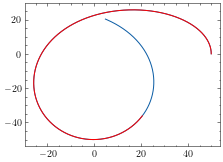

In [28]:
plt.plot(o_gala.pos.x,o_gala.pos.y)
plt.plot(ws_jax[:,0],ws_jax[:,1],color='r')

In [8]:
params = {'m': 1.0e12, 'a': 10.}
pot = Isochrone(m=params['m'], a=params['a'],units=usys,)  
t0 = 0.
dt = 0.5
n_steps = 2_000
w0 = jnp.array([50., 0., 0, (0*u.km/u.s).to(u.kpc/u.Myr).value, (150*u.km/u.s).to(u.kpc/u.Myr).value, (0*u.km/u.s).to(u.kpc/u.Myr).value])


w0_subhalo =  jnp.array([45., 0., 0, (0*u.km/u.s).to(u.kpc/u.Myr).value, (250*u.km/u.s).to(u.kpc/u.Myr).value, (0*u.km/u.s).to(u.kpc/u.Myr).value])


ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
### Compute the orbit with the provided potential
ws_jax = leapfrog_run(w0_subhalo, ts, pot.gradient)

M_sat = 1.0e4 # TODO: mass loss rate
pos_disp = .00
vel_disp = (5*u.km/u.s).to(u.kpc/u.Myr).value


splines = get_spl_funcs(ts, ws_jax)
spline_evals = eval_spl_funcs(ts[3], splines)


params_total = {'m': 1.0, 'a': 1.0, 'spline_eval_func': eval_spl_funcs, 'splines': splines, 't_min': 0., 't_max': 50000.,
         'm_ext': params['m'], 'a_ext': params['a']}

pot = Isochrone_centered(m=params_total['m'], a=params_total['a'],
                         spline_eval_func=params_total['spline_eval_func'],
                         splines=params_total['splines'],
                         t_min=params_total['t_min'],
                         t_max = params_total['t_max'],
                         m_ext = params_total['m_ext'],
                         a_ext = params_total['a_ext'],
                         units=usys,)  


ws_jax_time_dep = leapfrog_run(w0, ts, pot.gradient)




In [9]:
ws_jax_time_dep = leapfrog_run(w0, ts, pot.gradient)
pot_gala = gp.IsochronePotential(m=1.0e12*u.Msun,b=10*u.kpc,
                                              units=galactic)
H = gp.Hamiltonian(pot_gala)
prog_w0 = gd.PhaseSpacePosition(pos=[50, 0, 0.] * u.kpc, vel=[0, 150, 0.] * u.km/u.s)
o_gala = H.integrate_orbit(prog_w0,dt=0.5*u.Myr,n_steps=n_steps)


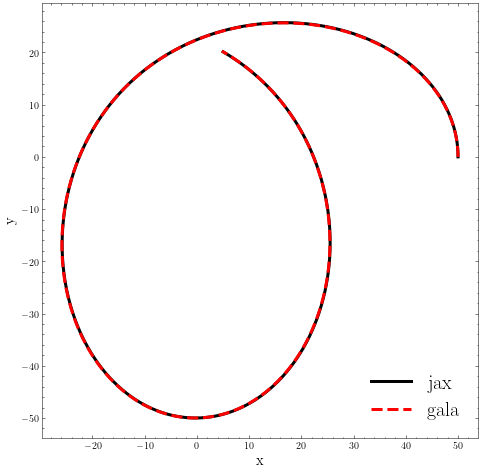

In [10]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.plot(ws_jax_time_dep[:,0],ws_jax_time_dep[:,1],lw=3,color='k',label='jax')
ax.plot(o_gala.x,o_gala.y,color='r',lw=3,ls='--',label='gala')
ax.legend(fontsize=20)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('y',fontsize=15)
ax.set_aspect('equal')

In [11]:
pos_close_arr, pos_far_arr, vel_close_arr, vel_far_arr = pot.gen_stream_ics(ts, w0, M_sat, pos_disp, vel_disp)

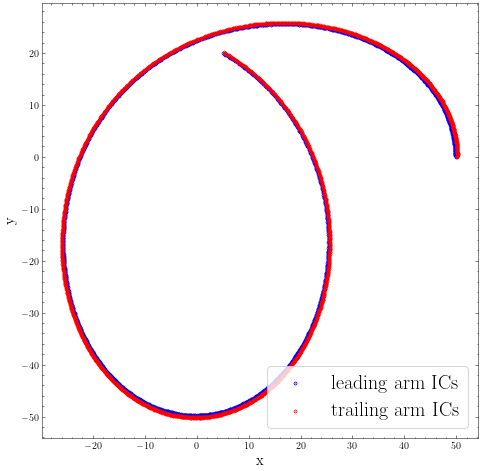

In [12]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

ax.scatter(pos_close_arr[:,0],pos_close_arr[:,1],lw=3,color='b',label='leading arm ICs',s=0.5,)
ax.scatter(pos_far_arr[:,0],pos_far_arr[:,1],lw=3,color='r',label='trailing arm ICs',s=0.5,)
ax.legend(fontsize=20,frameon=True)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('y',fontsize=15)
ax.set_aspect('equal')


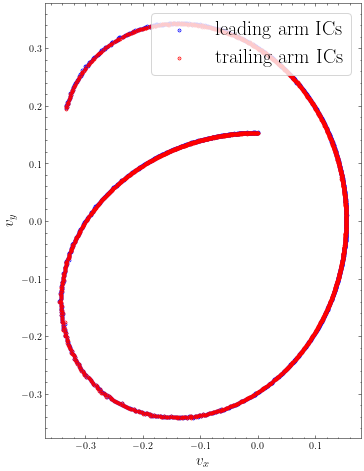

In [13]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

ax.scatter(vel_close_arr[:,0],vel_close_arr[:,1],lw=3,color='b',label='leading arm ICs',s=0.5,)
ax.scatter(vel_far_arr[:,0],vel_far_arr[:,1],lw=3,color='r',label='trailing arm ICs',s=0.5,)
ax.legend(fontsize=20,frameon=True,loc='upper right')
ax.set_xlabel(r'$v_x$',fontsize=15)
ax.set_ylabel(r'$v_y$',fontsize=15)
ax.set_aspect('equal')


In [63]:
import tqdm

In [533]:
w0_lead_gala = gd.PhaseSpacePosition(pos=pos_close_arr.T*u.kpc,vel=vel_close_arr.T*u.kpc/u.Myr)
final_pos_gala = np.zeros((len(ts)-1,6))
for i in tqdm.tqdm(range(len(ts)-1)):
    t_int = np.linspace(ts[i],ts[-1],2000)
    o = H.integrate_orbit(w0_lead_gala[i],t=t_int*u.Myr)[-1]
    final_pos_gala[i,:] = np.hstack([o.pos.xyz.value.T,o.vel.d_xyz.value.T])
    

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 439.75it/s]


In [534]:
t_int

array([ 999.5       ,  999.50025013,  999.50050025, ...,  999.99949975,
        999.99974987, 1000.        ])

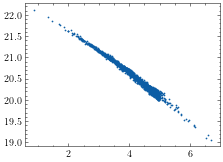

In [535]:
plt.scatter(final_pos_gala[:,0],final_pos_gala[:,1],s=0.5)

In [536]:
ts

Array([0.000e+00, 5.000e-01, 1.000e+00, ..., 9.990e+02, 9.995e+02,
       1.000e+03], dtype=float64)

In [484]:
pos_far_arr.shape

(2000, 3)

In [485]:
vel_far_arr.shape

(2000, 3)

In [295]:
i = 0
t_particle = jax.lax.dynamic_slice(ts,(i,),(len(ts)-i,))
t_particle

Array([0.000e+00, 5.000e-01, 1.000e+00, ..., 9.990e+02, 9.995e+02,
       1.000e+03], dtype=float64)

In [296]:
usys

<UnitSystem (kpc, Myr, solMass, rad)>

In [104]:
params = {'m': 1.0e12, 'a': 10.}
pot = Isochrone(m=params['m'], a=params['a'],units=usys,)  
t0 = 0
dt = 0.5
n_steps = 4_000
w0 = jnp.array([50., 0., 0, (0*u.km/u.s).to(u.kpc/u.Myr).value, (150*u.km/u.s).to(u.kpc/u.Myr).value, (0*u.km/u.s).to(u.kpc/u.Myr).value])


w0_subhalo =  jnp.array([45., 0., 0, (0*u.km/u.s).to(u.kpc/u.Myr).value, (250*u.km/u.s).to(u.kpc/u.Myr).value, (0*u.km/u.s).to(u.kpc/u.Myr).value])


ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
### Compute the orbit with the provided potential
ws_jax = leapfrog_run(w0_subhalo, ts, pot.gradient)

M_sat = 1.0e4 # TODO: mass loss rate
pos_disp = .00
vel_disp = (5*u.km/u.s).to(u.kpc/u.Myr).value



#lead_ics = jnp.zeros((len(ws_jax),6))
#trail_ics = jnp.zeros((len(ws_jax),6))

#for i in range(len(ws_jax)):
#    pos_close, pos_far, vel_close, vel_far = pot.release_model(ws_jax[i,:3], ws_jax[i,3:], M_sat, pos_disp, vel_disp)
    

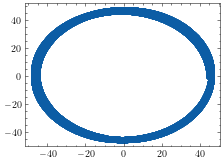

In [105]:
plt.scatter(ws_jax[:,0],ws_jax[:,1])

In [106]:
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
def get_spl_funcs(ts,ws):
    return [InterpolatedUnivariateSpline(ts,ws[:,i],k=3) for i in range(3)]

def eval_spl_funcs(ts, spl_funcs):
    return jnp.array([spl_funcs[i](ts) for i in range(3)])
#spl_x = InterpolatedUnivariateSpline(ts,ws_jax[:,0],k=3)
#spl_y = InterpolatedUnivariateSpline(ts,ws_jax[:,1],k=3)

splines = get_spl_funcs(ts, ws_jax)
spline_evals = eval_spl_funcs(ts[3], splines)

In [107]:
params = {'m': 0.0, 'a': 1.0, 'spline_eval_func': eval_spl_funcs, 'splines': splines, 't_min': 0., 't_max': 50000.,
         'm_ext': 1.0e12, 'a_ext': 10.}

pot = Isochrone_centered(m=params['m'], a=params['a'],
                         spline_eval_func=params['spline_eval_func'],
                         splines=params['splines'],
                         t_min=params['t_min'],
                         t_max = params['t_max'],
                         m_ext = params['m_ext'],
                         a_ext = params['a_ext'],
                         units=usys,)  


ws_jax_time_dep = leapfrog_run(w0, ts, pot.gradient)


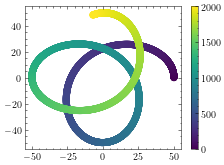

In [108]:
plt.scatter(ws_jax_time_dep[:,0],ws_jax_time_dep[:,1],c=ts,rasterized=True)
plt.colorbar()

In [109]:
M_sat = 1.0e4

In [110]:
lead_arm, trail_arm = pot.gen_stream_final(ts, w0, M_sat, pos_disp, vel_disp)

In [111]:
trail_arm.shape

(4000, 6)

In [112]:
lead_arm[4]

Array([-7.85247679e+00,  4.73463327e+01, -1.89712329e-02, -1.48014122e-01,
       -7.69234734e-02, -3.89401179e-06], dtype=float64)

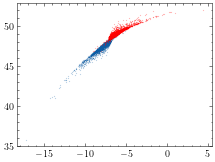

In [113]:
#plt.plot(gala_orb.x,gala_orb.y,color='r')
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=.01,zorder=2)
plt.scatter(trail_arm[:,0],trail_arm[:,1],s=.01,zorder=2,color='r')

#plt.xlim(-70,-40)
#plt.
#plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.05)

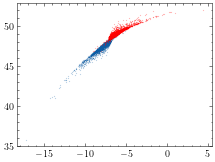

In [114]:
#plt.plot(gala_orb.x,gala_orb.y,color='r')
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=.01,zorder=2)
plt.scatter(trail_arm[:,0],trail_arm[:,1],s=.01,zorder=2,color='r')

#plt.xlim(-70,-40)
#plt.
#plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.05)

In [115]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
import matplotlib.pyplot as plt
pot = gp.IsochronePotential(m=1.0e12*u.Msun,b=10*u.kpc,
                                              units=galactic)
H = gp.Hamiltonian(pot)
prog_w0 = gd.PhaseSpacePosition(pos=[50, 0, 0.] * u.kpc,
                                 vel=[0, 150, 0.] * u.km/u.s)

df = ms.FardalStreamDF()
prog_mass = 1.0e4 * u.Msun
gen = ms.MockStreamGenerator(df, H)
stream, prog = gen.run(prog_w0, prog_mass,
                        dt=.5 * u.Myr, n_steps=4000,release_every=1,n_particles=1)

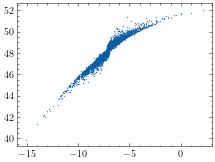

In [116]:
plt.scatter(stream.x,stream.y,s=0.0905)

In [117]:
stream.x.shape

(8002,)

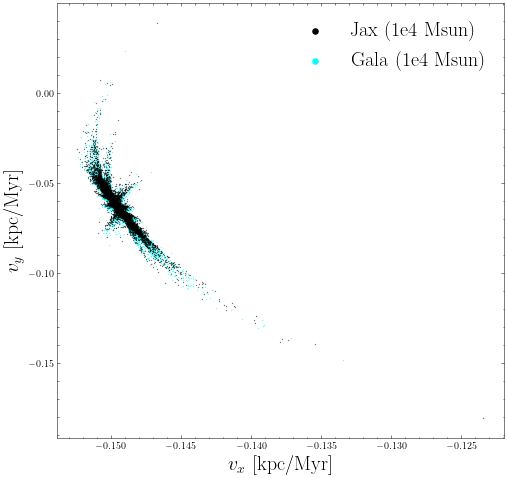

In [124]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
s = 0.05
ax.scatter(lead_arm[:,3],lead_arm[:,4],s=s,zorder=2,color='k',label='Jax (1e4 Msun)',rasterized=True)
ax.scatter(trail_arm[:,3],trail_arm[:,4],s=s,zorder=2,color='k',rasterized=True)

ax.scatter(stream.v_x,stream.v_y,s=s,color='cyan',label='Gala (1e4 Msun)',rasterized=True)
lgnd=ax.legend(fontsize=20)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
ax.set_xlabel('$v_x$ [kpc/Myr]',fontsize=20)
ax.set_ylabel('$v_y$ [kpc/Myr]',fontsize=20)

#####plt.savefig('FurtherTuned_jaxvgala_mockstream_Samemasses.pdf',bbox_inches='tight')
#plt.savefig('alignment_jax_galavxvy.pdf',bbox_inches='tight')

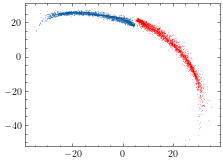

In [151]:
#plt.plot(gala_orb.x,gala_orb.y,color='r')
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=.01,zorder=2)
plt.scatter(trail_arm[:,0],trail_arm[:,1],s=.01,zorder=2,color='r')

#plt.xlim(-70,-40)
#plt.
#plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.05)

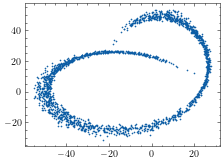

In [9]:
#plt.plot(gala_orb.x,gala_orb.y,color='r')
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=.4,zorder=2)

#plt.xlim(-70,-40)
#plt.
#plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.05)

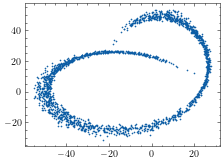

In [10]:
#plt.plot(gala_orb.x,gala_orb.y,color='r')
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=.4,zorder=2)

#plt.xlim(-70,-40)
#plt.
#plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.05)

In [11]:
lead_arm.shape

(2000, 6)

Text(0, 0.5, '$y$ [kpc]')

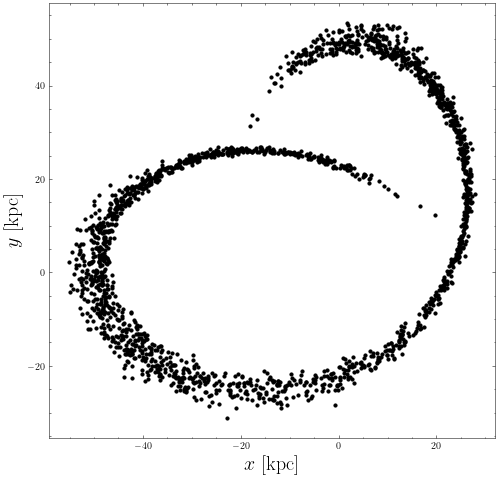

In [12]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(lead_arm[:,0],lead_arm[:,1],s=10,color='k')
ax.set_xlabel(r'$x$ [kpc]',fontsize=20)
ax.set_ylabel(r'$y$ [kpc]',fontsize=20)
##plt.savefig('sample_stream.pdf',bbox_inches='tight')

In [13]:
(.05*u.kpc/u.Myr).to(u.km/u.s)

<Quantity 48.88961108 km / s>

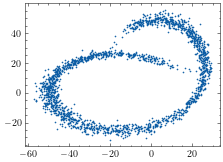

In [68]:
import jax.scipy.stats as statsjax
kde = statsjax.gaussian_kde(lead_arm[:,:2].T,bw_method=.05)
key = jax.random.PRNGKey(3)
samps = kde.resample(key,[len(lead_arm)]).T
ll = kde.logpdf(lead_arm[:,:2].T)
plt.scatter(samps[:,0],samps[:,1],s=.4)

In [69]:
import jax.scipy.stats as statsjax

def stream_gradients_kde(params,ts,w0,Msat, pos_disp, vel_disp, kde, units):
    #pot = Isochrone(m=params['m'], a=params['a'],units=units)
    #lead_arm, trail_arm = pot.gen_stream_final(ts, w0, Msat, pos_disp, vel_disp)
    
    # Compute the gradient of the final position with respect to the potential parameters
    def gradient_fn(params):
        params_else = {'spline_eval_func': eval_spl_funcs, 'splines': splines, 't_min': 0., 't_max': 50000.,
         'm_ext': 1.0e12, 'a_ext': 10.0}

        pot_with_params = Isochrone_centered(m=params['m'], a=params['a'],
                         spline_eval_func=params_else['spline_eval_func'],
                         splines=params_else['splines'],
                         t_min=params_else['t_min'],
                         t_max = params_else['t_max'],
                         m_ext = params_else['m_ext'],
                         a_ext = params_else['a_ext'],
                         units=usys,)  
        
        
        #############pot_with_params = Isochrone(m=params['m'], a=params['a'],units=units)
        lead_arm, trail_arm = pot_with_params.gen_stream_final(ts, w0, Msat, pos_disp, vel_disp)
        #kde = statsjax.gaussian_kde(lead_arm.T,bw_method=.07)
        log_like = jnp.sum(kde.logpdf(lead_arm[:,:2].T)) 
        return log_like#jnp.sum(lead_arm**2) 
    # Compute the gradient using JAX's autodiff
    gradient_eval = jax.jacfwd(gradient_fn)(params)
    
    ####grad_eval_func = lambda params: jax.jacfwd(gradient_fn)(params)
    ####second_grad_eval = jax.jacfwd(grad_eval_func)(params)
    
    return gradient_eval, None###second_grad_eval
    
params_ = {'m': params['m'], 'a': params['a']}

gradient_eval, second_gradient = stream_gradients_kde(params_,ts,w0,M_sat,pos_disp,vel_disp, kde, usys)
    


In [2]:
gradient_eval

NameError: name 'gradient_eval' is not defined

In [58]:
gradient_eval

{'a': Array(0.00073853, dtype=float64),
 'm': Array(-1.02281395e-10, dtype=float64)}

In [39]:
gradient_eval

{'a': Array(0., dtype=float64), 'm': Array(-0., dtype=float64)}

In [67]:
params_ = {'m': params['m'], 'a': params['a']}

gradient_eval_2d, second_gradient_2d = stream_gradients_kde(params_,ts,w0,M_sat,pos_disp,vel_disp, kde, usys)
    

In [17]:
(.01*u.kpc/u.Myr).to(u.km/u.s)

<Quantity 9.77792222 km / s>

In [40]:
np.log10(params['m']), params['a']

(7.0, 1.0)

In [41]:
gradient_eval

{'a': Array(-0.06254839, dtype=float64),
 'm': Array(3.20675563e-09, dtype=float64)}

In [68]:
gradient_eval_2d

{'a': Array(1.47724978, dtype=float64),
 'm': Array(-2.04594388e-07, dtype=float64)}

In [42]:
Mass_unit = 1e6
I = -jnp.array([ [second_gradient['a']['a'],second_gradient['a']['m']*(Mass_unit) ],
            [second_gradient['a']['m']*Mass_unit, second_gradient['m']['m']*(Mass_unit**2) ] ])
I_inv = np.array(jnp.linalg.inv(I))


In [70]:
Mass_unit = 1e6
I = -jnp.array([ [second_gradient_2d['a']['a'],second_gradient_2d['a']['m']*(Mass_unit) ],
            [second_gradient_2d['a']['m']*Mass_unit, second_gradient_2d['m']['m']*(Mass_unit**2) ] ])
I_inv_2d = np.array(jnp.linalg.inv(I))
I_inv_2d

array([[0.14517923, 0.55630666],
       [0.55630666, 3.34432455]])

In [44]:
e_val_true, e_vec_true = jnp.linalg.eig(I_inv)
e_vec_true_0 = e_vec_true[:,np.argmax(e_val_true)]
e_vec_true_1 = e_vec_true[:,np.argmin(e_val_true)]

theta_true = np.real(np.arctan(e_vec_true_1[0]/e_vec_true_0[0]))
w_true = 2*np.sqrt(np.real(e_val_true[0]))
h_true = 2*np.sqrt(np.real(e_val_true[1]))

In [71]:
e_val_true, e_vec_true = jnp.linalg.eig(I_inv_2d)
e_vec_true_0 = e_vec_true[:,np.argmax(e_val_true)]
e_vec_true_1 = e_vec_true[:,np.argmin(e_val_true)]

theta_true_2d = np.real(np.arctan(e_vec_true_1[0]/e_vec_true_0[0]))
w_true_2d = 2*np.sqrt(np.real(e_val_true[0]))
h_true_2d = 2*np.sqrt(np.real(e_val_true[1]))

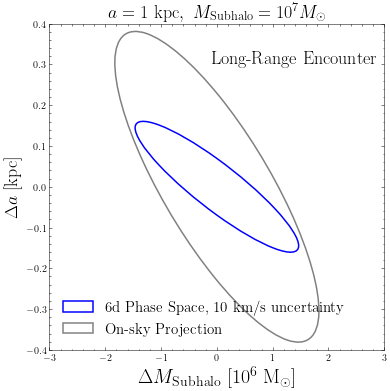

In [120]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
ellipse_true = Ellipse(
        xy=(0, 0),  # Center of the ellipse
        width=w_true,
        height=h_true,
        angle=np.rad2deg(theta_true),  # Rotation angle in degrees
        fill=False,  # You can set this to True if you want a filled ellipse
        color='b' ,lw=1.5,label=r'6d Phase Space, 10 km/s uncertainty' # Color of the ellipse
    )

ellipse_2d = Ellipse(
        xy=(0, 0),  # Center of the ellipse
        width=w_true_2d,
        height=h_true_2d,
        angle=np.rad2deg(theta_true_2d),  # Rotation angle in degrees
        fill=False,  # You can set this to True if you want a filled ellipse
        color='grey' ,lw=1.5,label=r'On-sky Projection' # Color of the ellipse
    )
c1 = ax.add_patch(ellipse_true)
c2 = ax.add_patch(ellipse_2d)
#ax.set_xscale('log')
ax.set_title(r'$a = 1 \ \mathrm{kpc}, \ M_{\rm Subhalo} = 10^7 M_{\odot}$',fontsize=18)
ax.set_xlim(-3,3)

#ax.set_xlim(-1e6,1e6)
ax.set_ylim(-.4,.4)
ax.legend(fontsize=15,frameon=False,loc ='lower left')
ax.set_xlabel(r'$\Delta M_{\rm Subhalo} \ \mathrm{[10^6 ~M_\odot]}$',fontsize=20)
ax.text(-.1,.3,'Long-Range Encounter',fontsize=18)
ax.set_ylabel(r'$\Delta a \ \mathrm{[kpc]}$',fontsize=18)
#############ax.set_aspect('equal')
# plt.savefig('subhalo_constraint.pdf',bbox_inches='tight')

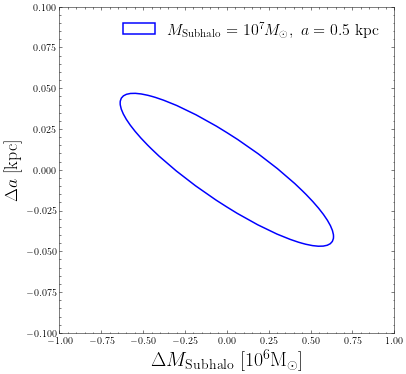

In [797]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
_=ellipse_true = Ellipse(
        xy=(0, 0),  # Center of the ellipse
        width=w_true,
        height=h_true,
        angle=np.rad2deg(theta_true),  # Rotation angle in degrees
        fill=False,  # You can set this to True if you want a filled ellipse
        color='b' ,lw=1.5,label=r'$M_{\rm Subhalo} = 10^7 M_{\odot}, \ a = 0.5 \ \mathrm{kpc}$' # Color of the ellipse
    )
c1 = ax.add_patch(ellipse_true)
#ax.set_xscale('log')
ax.set_xlim(-1,1)
#ax.set_xlim(-1e6,1e6)
ax.set_ylim(-.1,.1)
ax.legend(fontsize=16)
ax.set_xlabel(r'$\Delta M_{\rm Subhalo} \ \mathrm{[10^6 M_\odot]}$',fontsize=20)
ax.set_ylabel(r'$\Delta a \ \mathrm{[kpc]}$',fontsize=18)
###plt.savefig('subhalo_constraint.pdf',bbox_inches='tight')

(-0.1, 0.1)

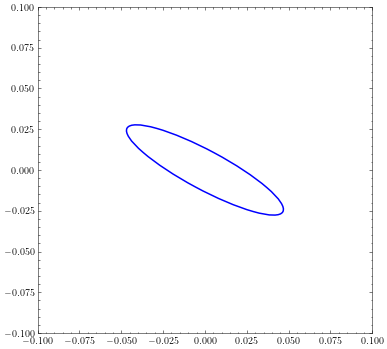

In [739]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
_=ellipse_true = Ellipse(
        xy=(0, 0),  # Center of the ellipse
        width=w_true,
        height=h_true,
        angle=np.rad2deg(theta_true),  # Rotation angle in degrees
        fill=False,  # You can set this to True if you want a filled ellipse
        color='b' ,lw=1.5,label=None # Color of the ellipse
    )
c1 = ax.add_patch(ellipse_true)
#ax.set_xscale('log')
ax.set_xlim(-.1,.1)
ax.set_ylim(-.1,.1)

In [740]:
10**(.1)

1.2589254117941673

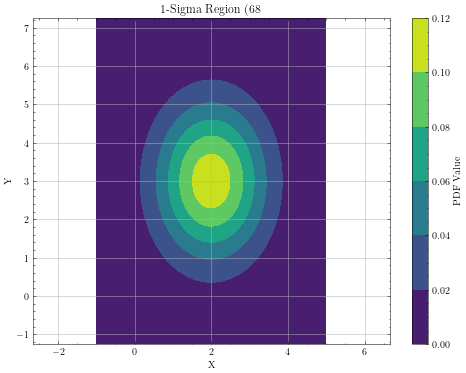

In [654]:
# Define the covariance matrix
covariance_matrix = np.array([[1.0, .1],
                              [.1, 2.0]])

# Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Calculate the standard deviations along the principal axes
sigma_x = np.sqrt(eigenvalues[0])
sigma_y = np.sqrt(eigenvalues[1])

# Define the center of the Gaussian distribution
mean = np.array([2.0, 3.0])

# Create a grid of points around the mean
x = np.linspace(mean[0] - 3 * sigma_x, mean[0] + 3 * sigma_x, 400)
y = np.linspace(mean[1] - 3 * sigma_y, mean[1] + 3 * sigma_y, 400)
X, Y = np.meshgrid(x, y)

# Calculate the probability density function (PDF) for the Gaussian distribution
Z = np.exp(-0.5 * (((X - mean[0]) / sigma_x) ** 2 + ((Y - mean[1]) / sigma_y) ** 2)) / (2 * np.pi * sigma_x * sigma_y)

# Plot the 1-sigma region (68% confidence interval)
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=5, cmap='viridis')
plt.colorbar(label='PDF Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('1-Sigma Region (68% Confidence Interval) for 2D Gaussian')
plt.axis('equal')
plt.grid(True)
plt.show()

In [647]:
jnp.log10(jnp.sqrt(4.0e11))

Array(5.80103, dtype=float64)

In [600]:
np.sqrt(7)

2.6457513110645907

In [1198]:
np.sqrt(1e-4)*1000

10.0

In [960]:
10**np.sqrt(1.52e-10)

1.0000283885785286

In [945]:
I = -jnp.array([ [second_gradient['a']['a'],second_gradient['a']['m'] ],
            [second_gradient['a']['m'], second_gradient['m']['m'] ] ])
jnp.linalg.inv(I)

Array([[6.97522627e-09, 2.31555412e+02],
       [2.31555412e+02, 8.13557014e+12]], dtype=float64)

In [7]:
second_gradient['a']['m'], second_gradient['m']['a']

NameError: name 'second_gradient' is not defined

In [1238]:
params['m']

1000000000000.0

In [22]:
pot = Isochrone(m=params['m'], a=params['a'],units=usys,)  # Create the potential with the given parameters
    
# Example Orbit:
t0 = 0
ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
    
### Compute the orbit with the provided potential
w_orb = leapfrog_run(w0, ts, pot.gradient)

In [23]:
@jax.jit
def gauss_pt(x_eval, x_mean):
    return -0.5*jnp.sum(jnp.square(x_eval - x_mean))
gauss_pt(w_orb[-1,:],w_orb[-1,:])

Array(-0., dtype=float64)

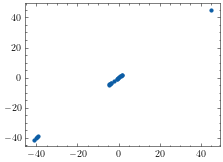

In [1254]:
import jax.scipy.stats as statsjax
#kde = statsjax.gaussian_kde(w_orb[-1,:],bw_method=.04)
#key = jax.random.PRNGKey(3)
#samps = kde.resample(key,[20]).T
#ll = kde.logpdf(lead_arm[:,:].T)
#plt.scatter(samps[:,0],samps[:,1],s=10)

In [33]:
def compute_orbit_and_gradients(params,w0,dt,n_steps,units):
    pot = Isochrone(m=params['m'], a=params['a'],units=units,)  # Create the potential with the given parameters
    
    # Example Orbit:
    #w0 = jnp.array([10, 0, 0, 0, .204, 0])
    t0 = 0
    #dt = 0.1
    #n_steps = 10000
    ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
    
    ### Compute the orbit with the provided potential
    ####################ws_jax = leapfrog_run(w0, ts, pot.gradient)
    
    # Compute the gradient of the final position with respect to the potential parameters
    def gradient_fn(params):
        pot_with_params = Isochrone(m=params['m'], a=params['a'],units=units)
        ws_with_params = leapfrog_run(w0, ts, pot_with_params.gradient)
        final_position = ws_with_params[-1, :]  # Extract final position
        return gauss_pt(final_position,w_orb[-1,:])
        #return final_position
    
    # Compute the gradient using JAX's autodiff
    gradient = jax.jacfwd(gradient_fn)(params)
    
    return gradient

In [32]:
params

{'m': 1000000000000.0, 'a': 10.0}

In [34]:
gg = compute_orbit_and_gradients(params,w0,dt,n_steps,usys)

In [35]:
gg

{'a': Array(-213.5123923, dtype=float64),
 'm': Array(6.81011456e-09, dtype=float64)}

In [399]:
params = {'m': 5e11, 'a': 10.}
pot = Hernquist(m=params['m'], a=params['a'],units=usys,)  
t0 = 0
dt = 0.5
n_steps = 10_000
ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
### Compute the orbit with the provided potential
##ws_jax = leapfrog_run(w0, ts, pot.gradient)

M_sat = 1.0e4 # TODO: mass loss rate
pos_disp = .001
vel_disp = (20*u.km/u.s).to(u.kpc/u.Myr).value#.05

pos_close_arr, pos_far_arr, vel_close_arr, vel_far_arr = pot.gen_stream_ics(ts, w0, Msat, pos_disp, vel_disp)

In [333]:
#release_time_arr = get_stripping_time_arr(ts)

In [308]:
ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
ts

Array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.998e+03, 9.999e+03,
       1.000e+04], dtype=float64)

In [309]:
def get_stripping_time_arr(ts):
    t_release_arr = [ts[i:] for i in range(len(ts))]
    return t_release_arr

# Example usage:
#ts = jnp.array([1, 2, 3, 4, 5])
result = get_stripping_time_arr(ts)
print(result)

KeyboardInterrupt: 

In [319]:
jax.lax.slice(tt,(1,),(len(tt),))

Array([2, 3, 4, 5], dtype=int64)

In [312]:
from jax import vmap

def get_stripping_time_arr(ts):
    # Create a batched version of ts
    batched_ts = jnp.stack([ts] * len(ts))
    
    # Create a function to slice each row
    def slice_row(i, arr):
        return jax.lax.slice(arr,i,-1)

    # Use vmap to apply the slicing function to each row
    t_release_arr = vmap(slice_row)(jnp.arange(len(ts)), batched_ts)
    
    return t_release_arr
# Example usage:
tt = jnp.array([1, 2, 3, 4, 5])
result = get_stripping_time_arr(tt)
print(result)

TypeError: iteration over a 0-d array

In [376]:
lead_arm, trail_arm = pot.gen_stream(ts, w0, Msat, pos_disp, vel_disp)

In [ ]:
plt.scatter(lead_arm[:,-1,0],lead_arm[:,-1,1],s=0.5,rasterized=True)

In [404]:
(50*u.km/u.s).to(u.kpc/u.Myr).value

<Quantity 0.02045424 kpc / Myr>

In [405]:
lead_arm, trail_arm = pot.gen_stream_final(ts, w0, Msat, pos_disp, (50*u.km/u.s).to(u.kpc/u.Myr).value)

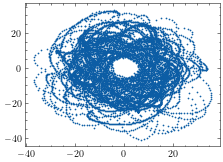

In [406]:
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=0.5,rasterized=True)

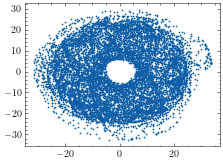

In [378]:
plt.scatter(lead_arm[:,-1,0],lead_arm[:,-1,1],s=0.5,rasterized=True)

In [198]:
# Define a step function that adds an input to the carry state
def step(carry, x):
    return carry + x, carry + x

# Sequence of input values
inputs = jnp.array([1, 2, 3, 4, 5])

# Initial carry state
init_carry = jnp.array(0)

# Use jax.lax.scan to iterate over the inputs
final_carry, results = jax.lax.scan(step, init_carry, inputs)

print(final_carry)  # Output: 15 (sum of all input values)
print(results)      # Output: [1, 3, 6, 10, 15] (cumulative sums)

15
[ 1  3  6 10 15]


In [115]:
key = jax.random.PRNGKey(30302)
jax.random.normal(key,shape=(3,))

Array([ 0.23298915, -1.04627168,  1.35807149], dtype=float64)

In [172]:
params = {'m': 1e10, 'a': 10.}
pot = Hernquist(m=params['m'], a=params['a'],units=usys,)  

x = jnp.array([25,10,10.])
v = jnp.array([.1,.05,.04])
Msat = 1.0e4
pos_disp = .01
vel_disp = .005
#pot.tidalr_mw(x,v,Msat)
pot.lagrange_pts(x, v, Msat,)
#pot.tidalr_mw(x,v,Msat)
#pot.d2phidr2_mw(x)
#pot.omega(x, v)
#pot.omega(x, v) ** 2 - pot.d2phidr2_mw(x)

(Array([24.72606542,  9.89042617,  9.89042617], dtype=float64),
 Array([25.27393458, 10.10957383, 10.10957383], dtype=float64))

In [165]:
(pot._G * Msat / (pot.omega(x, v) ** 2 - pot.d2phidr2_mw(x))) ** (1.0 / 3.0)

Array(nan, dtype=float64)

In [167]:
pot._G * Msat / (pot.omega(x, v) ** 2 - pot.d2phidr2_mw(x))

Array(-0.03117464, dtype=float64)

In [168]:
(-2)**(1/3)

(0.6299605249474367+1.0911236359717214j)

In [60]:
a_arr = jnp.linspace(10,11,30)
w0 = jnp.array([25., 0., 0, 0.01, .104, -0.004])
dt = 0.1
t0 = 0.
n_steps = 30_000
Delta_a = jnp.diff(a_arr)[0]
predicted_wf = jnp.zeros((len(a_arr),6))
true_wf = jnp.zeros((len(a_arr)-1,6))
for i in range(len(a_arr)):
    params = {'m': 5e11, 'a': a_arr[i]}
    result_ws, param_gradients = compute_orbit_and_gradients(params,w0,dt,n_steps,usys)
    pred = result_ws[-1] + param_gradients['a']*Delta_a 
    predicted_wf = predicted_wf.at[i,:].set( pred )
    if i > 0:
        true_wf = true_wf.at[i-1,:].set(result_ws[-1])
    
    

    

    
    

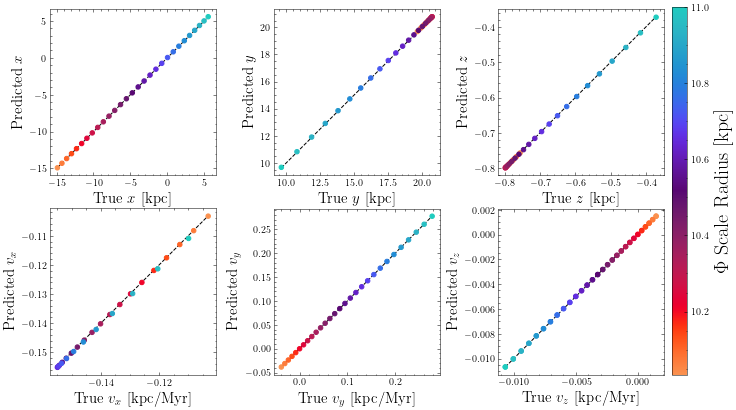

In [61]:
fig, ax = plt.subplots(2,3)
ax_flat = ax.flatten()
fig.set_size_inches(11,7)
for dim in range(6):
    xx = np.linspace(true_wf[:,dim].min(),true_wf[:,dim].max(),50)
    ax_flat[dim].plot(xx,xx,color='k',ls='--',zorder=0)

    ax_flat[dim].scatter(true_wf[:,dim], predicted_wf[:-1,dim],c=a_arr[1:],s=20,cmap=cmr.guppy)
    ax_flat[dim].set_aspect('equal')
fig.subplots_adjust(hspace=0.1,wspace=.35)
ax_flat[0].set_xlabel(r'True $x$ [kpc]',fontsize=15)
ax_flat[0].set_ylabel(r'Predicted $x$',fontsize=15)

ax_flat[1].set_xlabel(r'True $y$ [kpc]',fontsize=15)
ax_flat[1].set_ylabel(r'Predicted $y$',fontsize=15)

ax_flat[2].set_xlabel(r'True $z$ [kpc]',fontsize=15)
ax_flat[2].set_ylabel(r'Predicted $z$',fontsize=15)

ax_flat[3].set_xlabel(r'True $v_x$ [kpc/Myr]',fontsize=15)
ax_flat[3].set_ylabel(r'Predicted $v_x$',fontsize=15)

ax_flat[4].set_xlabel(r'True $v_y$ [kpc/Myr]',fontsize=15)
ax_flat[4].set_ylabel(r'Predicted $v_y$',fontsize=15)

ax_flat[5].set_xlabel(r'True $v_z$ [kpc/Myr]',fontsize=15)
ax_flat[5].set_ylabel(r'Predicted $v_z$',fontsize=15)

# Add a colorbar on the right of the subplots
cax = fig.add_axes([0.91, 0.14, 0.02, 0.73])  # Adjust the position and size of the colorbar
cbar = plt.colorbar(ax_flat[dim].scatter(true_wf[:,dim], predicted_wf[:-1,dim],c=a_arr[1:],s=20,cmap=cmr.guppy), cax=cax, orientation='vertical')
cbar.set_label('$\Phi$ Scale Radius [kpc]',fontsize=20)  # Set the label for the colorbar
##plt.savefig('TaylorExpansion_PotentialFinalSnap.pdf',bbox_inches='tight')



In [42]:
w0 = jnp.array([20, 0, 0, -.01, .104, -.03])
t0 = 0
dt = 0.1
n_steps = 20000
ts = np.arange(t0, t0 + dt * n_steps + dt/10., dt)
params = {'m': 5e11, 'a': 10.}
pot = Hernquist(m=params['m'], a=params['a'],units=usys,)

    

pos_disp = 0.01 #kpc   
vel_dis = (20*u.km/u.s).to(u.kpc/u.Myr).value
    

key = random.PRNGKey(0)  # Initialize a random key
num_orbits = 5000
ndim = 3

pos_samps = np.random.normal(loc=0,scale=pos_disp,size=(num_orbits,3))
vel_samps = np.random.normal(loc=0,scale=vel_dis,size=(num_orbits,3))


pos0 = pos_samps + w0[:3]
vel0 = vel_samps + w0[3:]
w0 = jnp.hstack([pos0,vel0])

orbs = []
final_snap = jnp.zeros((num_orbits,6))
for i in range(len(w0)):
    wcurr = w0[i]
    ws_jax = leapfrog_run(wcurr, ts, pot.gradient)
    orbs.append(ws_jax)
    
    final_snap = final_snap.at[i].set(ws_jax[-1,:])
    
    


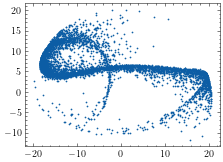

In [43]:
plt.scatter(final_snap[:,0],final_snap[:,1],rasterized=True,s=0.5)

In [51]:
gala_pot = gp.HernquistPotential(m=params['m'],c=params['a'],units=usys)
H = gp.Hamiltonian(gala_pot)
w_test = gd.PhaseSpacePosition(pos=w0[0][:3]*u.kpc,vel=w0[0][3:]*u.kpc/u.Myr)
orb_gala = H.integrate_orbit(w_test,dt=dt*u.Myr,n_steps=20000)

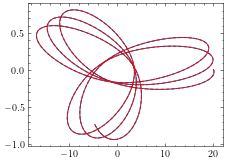

In [56]:
plt.plot(orb_gala.pos.x,orb_gala.pos.z)
plt.plot(orbs[0][:,0],orbs[0][:,2],color='r',ls='--')

(20001, 6)